# RNA Velocity Basics

Applied to the endocrine development in the pancreas, with lineage commitment to four major fates: α, β, δ and ε-cells.

In [26]:
import scvelo as scv
import pandas as pd

scv.logging.print_version()

Running scvelo 0.3.1 (python 3.11.6) on 2024-01-23 21:49.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [2]:
scv.settings.verbosity=3 
scv.settings.presenter_view = True        
scv.set_figure_params('scvelo')

# Load the Data

The analysis is based on the in-built [pancreas_data](https://scvelo.readthedocs.io/scvelo.datasets.pancreas). To run velocity analysis in other data, read file (loom, h5ad, csv...) to an AnnData object with `adata = scv.read('path/file.loom', cache=True)`. To merge a loom file into an already existing AnnData object, use `scv.utils.merge(adata, adata_loom)`.

In [3]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

scVelo is based on `adata`, an object that stores a data matrix `adata.X`, annotation of observations `adata.obs`, variables `adata.vars`, and unstructured annotations `adata.uns`. Names of obs and vars can be accessed via `adata.obs._names` and `adata.var_names`, respectively. AnnData objs can be sliced like dataframes, for example, `adata_subset = adata[:, list_of_gene_names]`. 

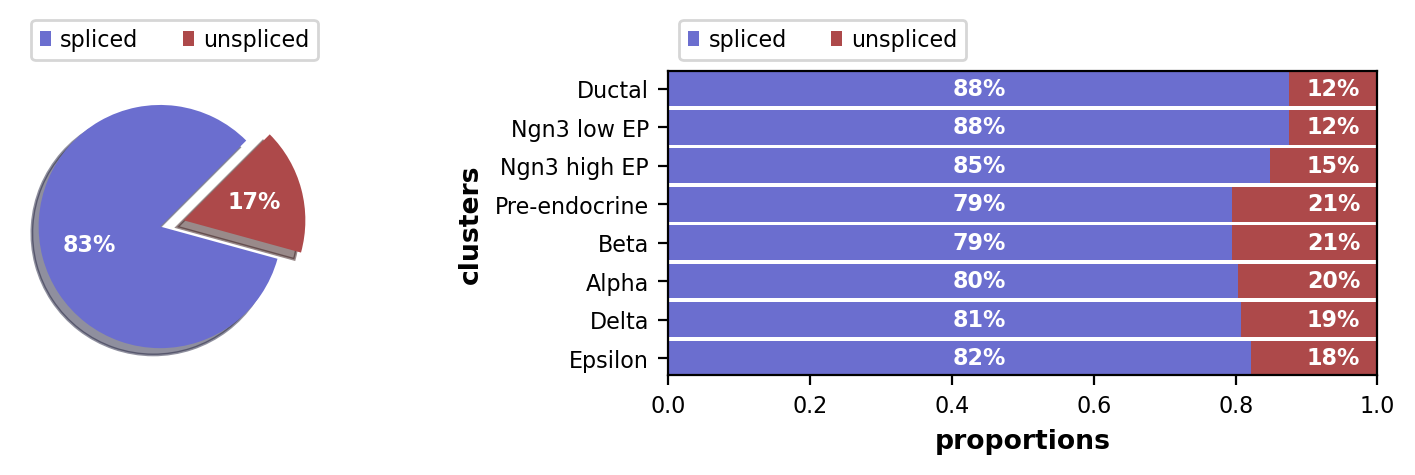

In [4]:
scv.pl.proportions(adata)

The proportions of spliced/unspliced counts are displayed. Depending on the protocol used (Drop-Seq, Smart-Seq), typically 10%-25% of unspliced molecules countaining intronic sequences. Also examine the variations on cluster level to verify consistency in splicing efficiency.

## Preprocess the Data

Preprocessing requisites consist of gene selection by detection (with a minimum number of counts) and high variability (dispersion), normalizing every cell by its total size and logarithmizing X. Filtering and normalization is applied in the same vein to spliced/unspliced counts and X. Logarithmizing is only applied to X. If X is already preprocessed from former analysis, it will not be touched.

This is summarized in `scv.pp.filter_and_normalize`, which runs:

Also need the first and second order moments (means and uncentered variances) computed among nearest neighbors in PCA state, summarized in `scv.pp.moments`, which internally computes `scv.pp.pca` and `scv.pp.neighbors`. First order is needed for deterministic velocity estimation, while stochastic estimation also requires second order moments.

In [25]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 55 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
computing moments based on connectivities


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Further preprocessing (such as batch effect correction) may be used to remove unwanted sources of variablity. Any additional preprocessing step only affects X and is not applied to spliced/unspliced counts.

## Estimate RNA velocity 

Velocities are vectors in gene expression space and represent the direction and speed of movement of the individual cells. Pos velocity indicates that gene is up-regulated, which occurs for cells that show higher abundance of unspliced mRNA for that gene than expected in a steady-state ratio. Neg velocity indicates that a gene is down-regulated. 

In [6]:
scv.tl.velocity(adata)

computing velocities


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


The computed velocities are stored in `adata.layers` just like count matrices. 

The combination of velocities across genes can than be used to estimate the future state of an individual cell. In order to project the velocities into a lower-dimensional embedding, transition probabilities of cell-to-cell transitions are estimated.

In [7]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/16 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Project the velocities 

The velocities are projected onto any embedding, specified by `basis`, and viualized in one of these ways: on cellular level `scv.pl.velocity_embedding`, as gridlines `scv.pl.velocity_embedding_grid`, or as streamlines with `scv.pl.velocity_embedding_stream`.

The data has an already pre-computed UMAP embedding and annotated clusters. These can be obtained with `scv.tl.umap` and `scv.tl.louvain`. All plotting functions are deafaulted to using `basis=umap` and `color=clusters`.

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


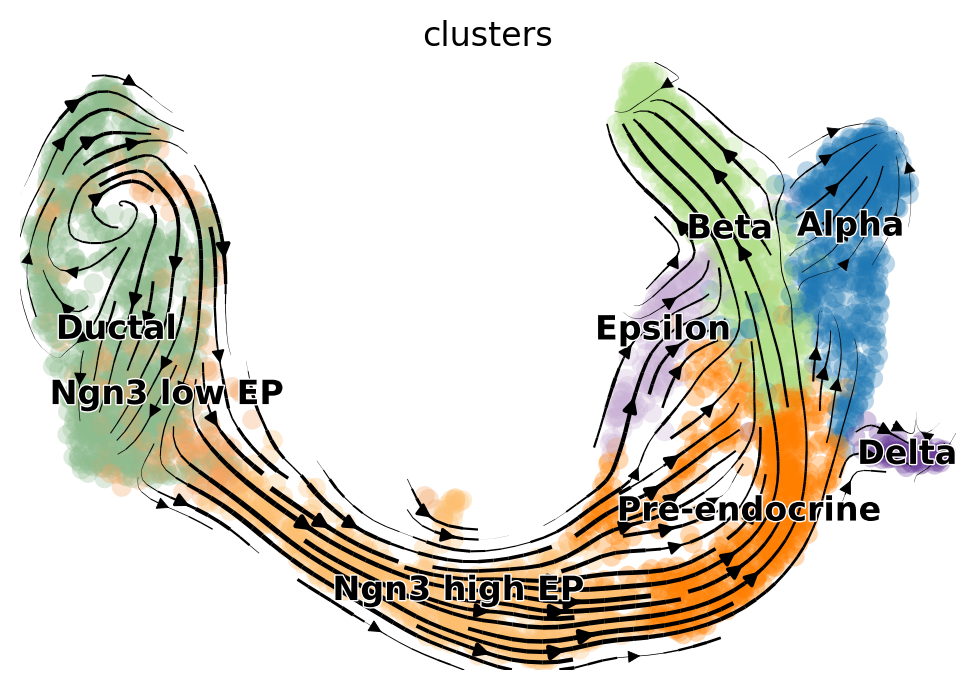

In [8]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

The velocity vector field displayed as streamlines yields fine-grained insights into the developmental processes. It accurately delineates the cycling population of ductal cells and endocrine progenitors. Further, it illuminates cell states of lineage commitment, cell-cycle exit, and endocrine cell differentiation.

The most fine-grained resolution of the velocity vector field we get at single-cell level, with each arrow showing the direction and speed of movement of an individual cell. That reveals, e.g., the early endocrine commitment of Ngn3-cells (yellow) and a clear-cut difference between near-terminal α-cells (blue) and transient β-cells (green).

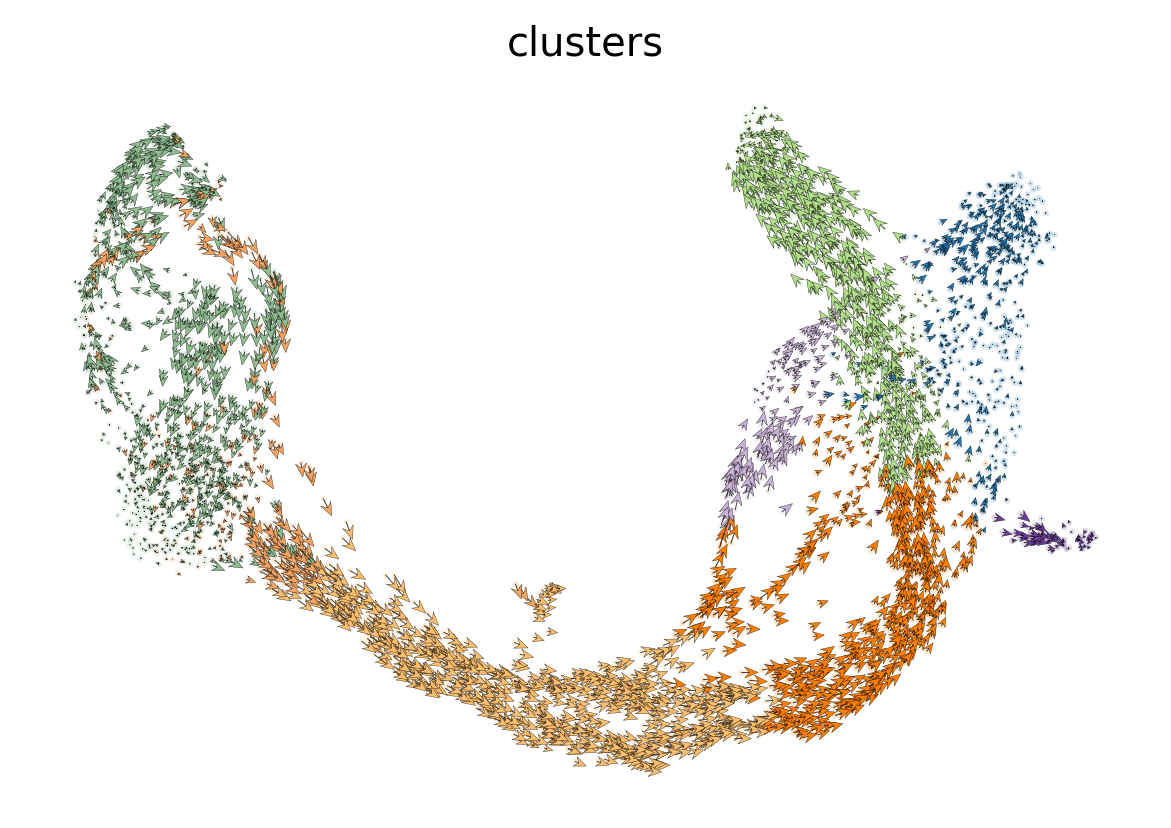

In [9]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120)

## Interprete the velocities

Examine individual gene dynamics via phase portraits to understand how inferred directions are supported by particular genes.

Transcriptional induction for a particular gene results in an increase of (newly transcribed) precursor unspliced mRNAs while, conversely, repression or absence of transcription results in a decrease of unspliced mRNAs. Spliced mRNAs is produced from unspliced mRNA and follows the same trend with a time lag. Time is a hidden/latent variable.

Examine the phase portraits of some marker genes, visualized with `scv.pl.velocity(adata, gene_names)` or `scv.pl.scatter(adata, gene_names)`.

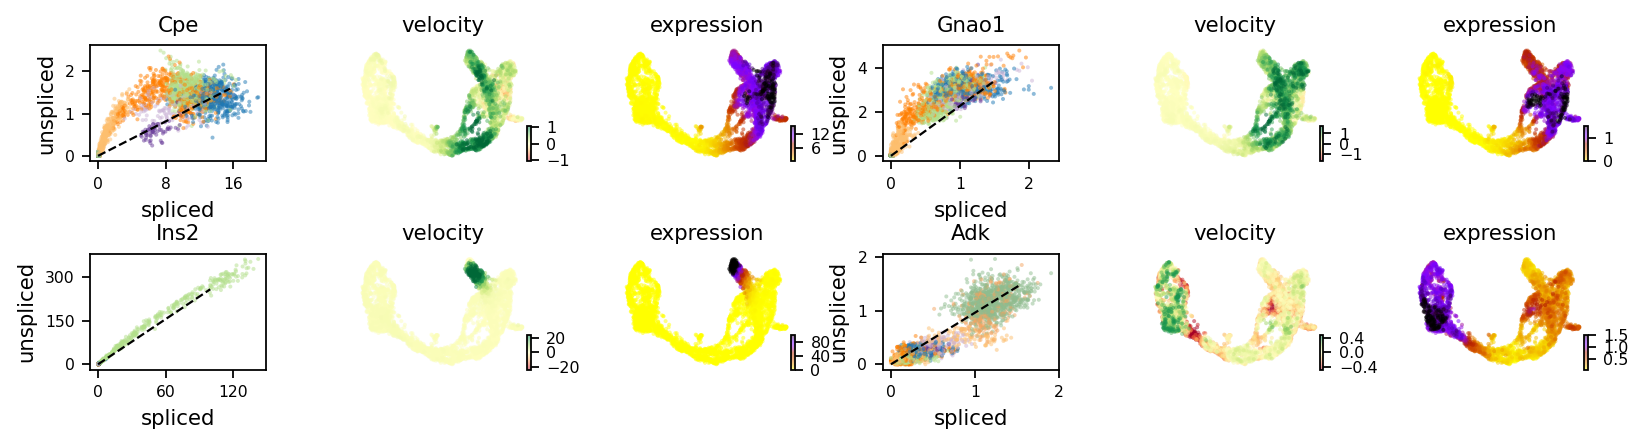

In [10]:
scv.pl.velocity(adata, ['Cpe', 'Gnao1', 'Ins2', 'Adk'], ncols=2)

*CPE* explains the directionality in the up-regulated Ngn3 (yellow) to Pre-endocrine (orange) to  β-cells (green), wihle *Adk* explains the directionality in the down-regulated Ductal (dark green) to Ngn3 (yellow)to the remaining endocrine cells.

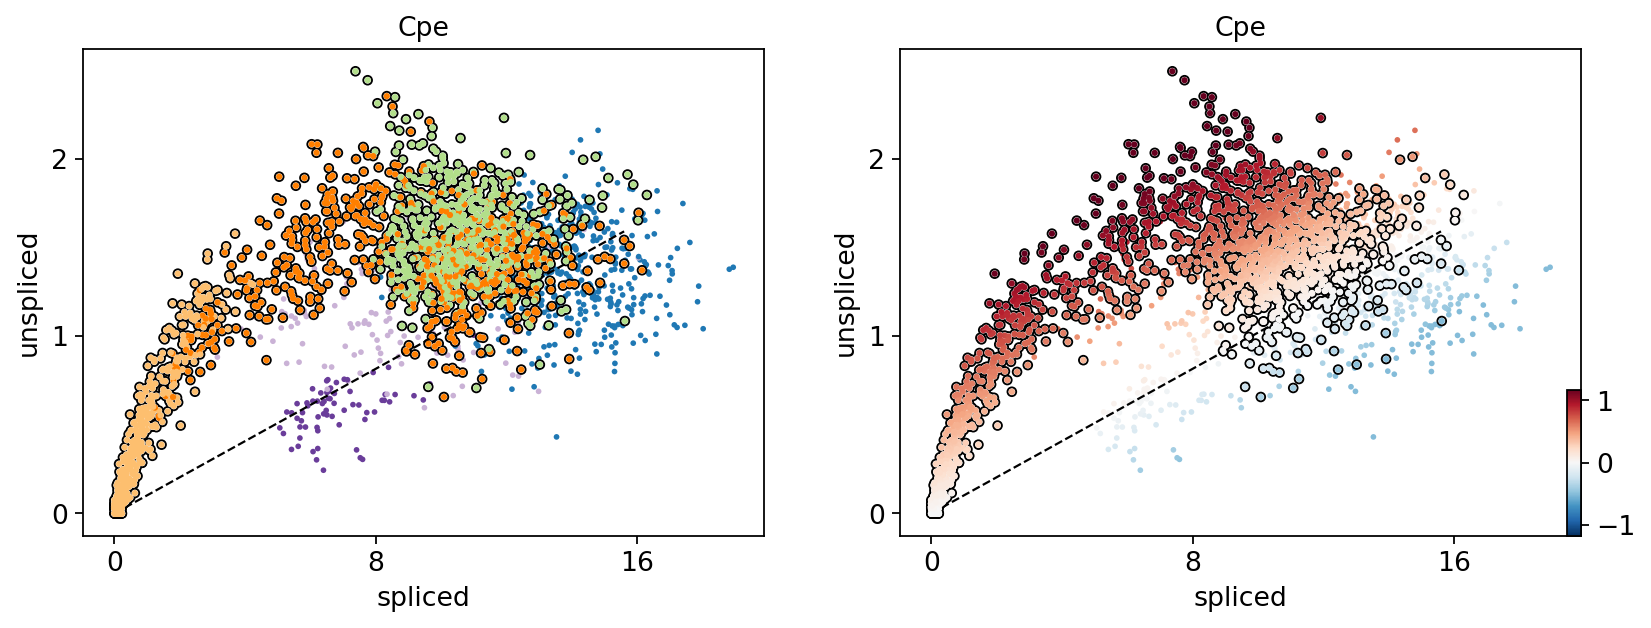

In [11]:
scv.pl.scatter(adata, 'Cpe', color=['clusters', 'velocity'],
              add_outline='Ngn3 high EP, Pre-endocrine, Beta')

## Identify important genes

Test which genes have cluster-specified differential velocity expressio, being significantly higher/lower compared to the remaining population. The module `scv.tl.rank_velocity_genes` runs a differentially velocity t-test and outputs a gene ranking for each cluster. Thresholds can be set (e.g. `min_corr`) to restrict the test on selection of gene candidates.

In [12]:
scv.tl.rank_velocity_genes(adata, groupby='clusters', min_corr=.3)

df = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scvelo/tools/utils.py:463: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


Ductal Ngn3 low EP Ngn3 high EP Pre-endocrine     Beta    Alpha    Delta  \
0  Notch2       Ptpn3        Pde1c           Pam     Pax6  Zcchc16    Zdbf2   
1    Sox5       Hacd1        Ptprs          Sdk1    Unc5c    Nlgn1   Spock3   
2   Krt19       Hspa8         Pclo        Baiap3     Nnat    Nell1  Akr1c19   
3   Hspa8      Gm8113     Rap1gap2         Abcc8  Tmem108   Prune2    Ptprt   
4    Ano6       Kcnq1        Ttyh2          Gnas    Ptprt     Ksr2   Snap25   

  Epsilon  
0   Tmcc3  
1    Heg1  
2  Gpr179  
3    Ica1  
4   Ncoa7

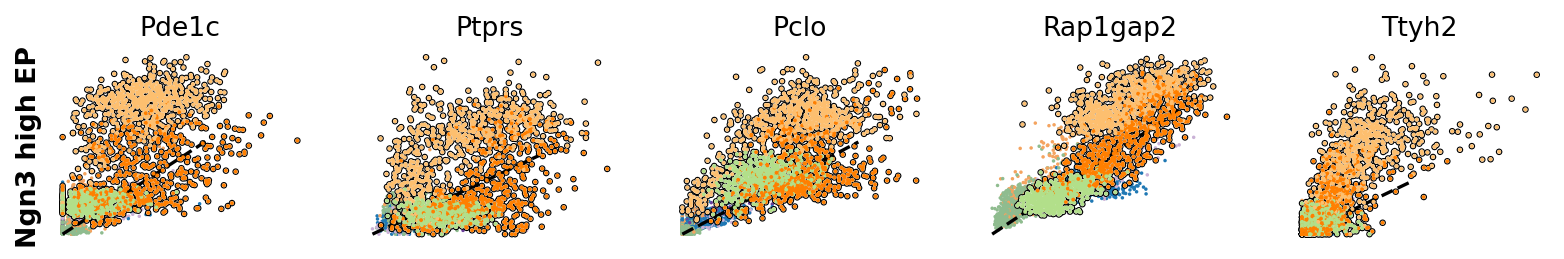

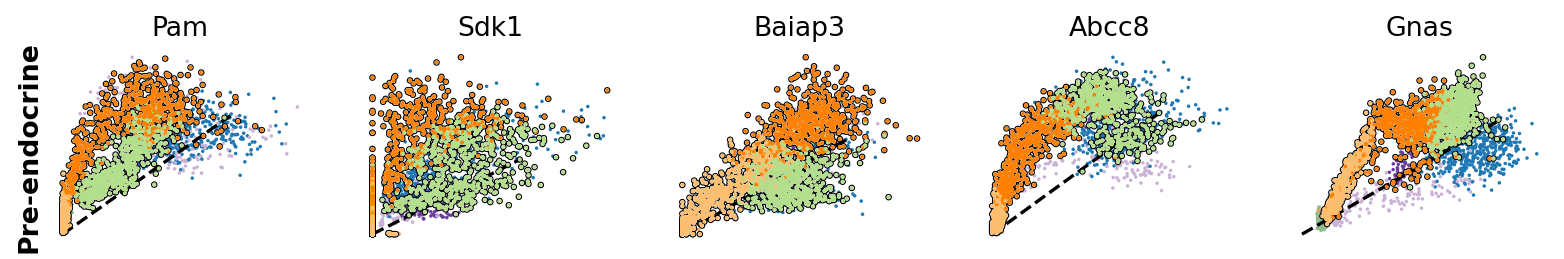

In [13]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              add_outline='Ngn3 high EP, Pre-endocrine, Beta')

scv.pl.scatter(adata, df['Ngn3 high EP'][:5], ylabel='Ngn3 high EP', **kwargs)
scv.pl.scatter(adata, df['Pre-endocrine'][:5], ylabel='Pre-endocrine', **kwargs)

The genes *Ptprs, Pclo, Pam, Abcc8, Gnas*, for instance, support the directionality from **Ngn3 high EP** (yellow) to **Pre-endocrine** (orange) to **Beta** (green).

## Velocities in cycling progenitors

The cell cycle detected by RNA velocity, is biologically affirmed by cell cycle scores (standardized scores of mean expression levels of phase marker genes).

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


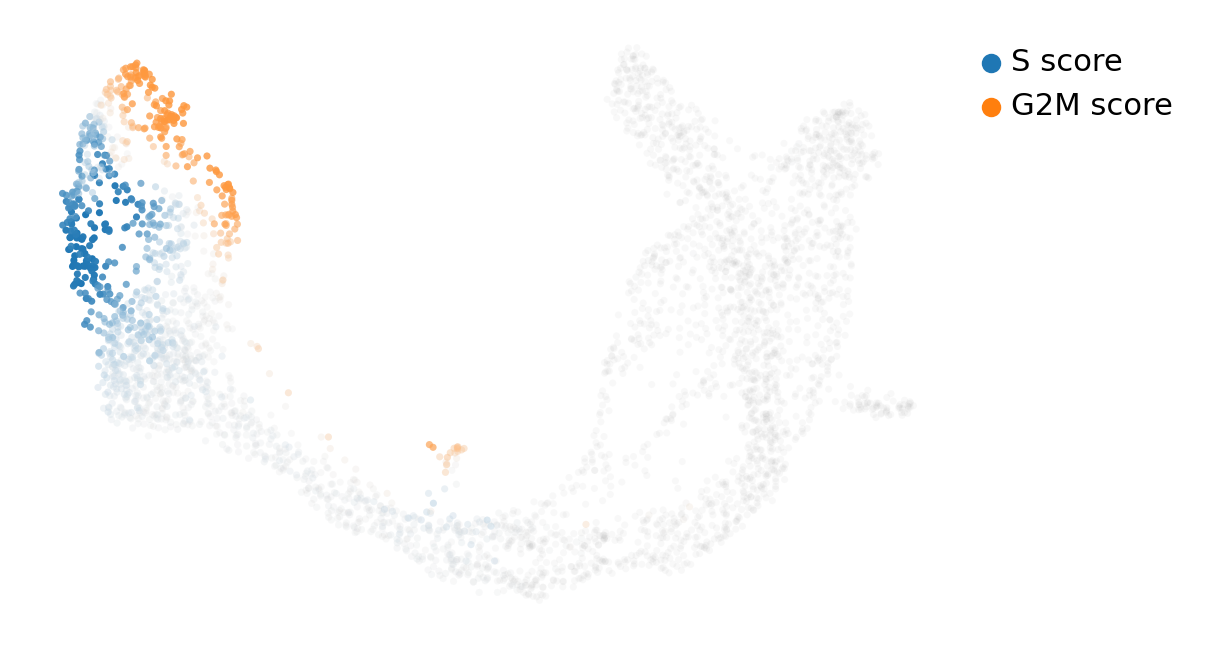

In [14]:
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

For the cycling Ductal cells, screen through S and G2M phase markers.Spearmans correlation score can be used to rank/sort the phase marker genes to then display their phase portaits.

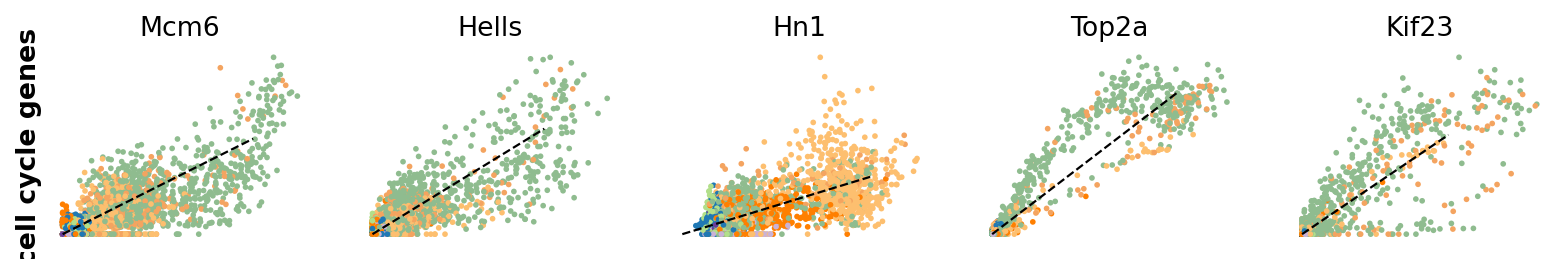

In [15]:
s_genes, g2m_genes = scv.utils.get_phase_marker_genes(adata)
s_genes = scv.get_df(adata[:, s_genes], 'spearmans_score', sort_values=True).index
g2m_genes = scv.get_df(adata[:, g2m_genes], 'spearmans_score', sort_values=True).index

kwargs = dict(frameon=False, ylabel='cell cycle genes')
scv.pl.scatter(adata, list(s_genes[:2]) + list(g2m_genes[:3]), **kwargs)

*Hells* and *Top2a* are well-suited to explain the vector field in the cycling progenitors. Top2a gets assigned a high velocity shortly before it actually peaks in the G2M phase. There, the negative velocity then perfectly matches the immediately following down-regulation.

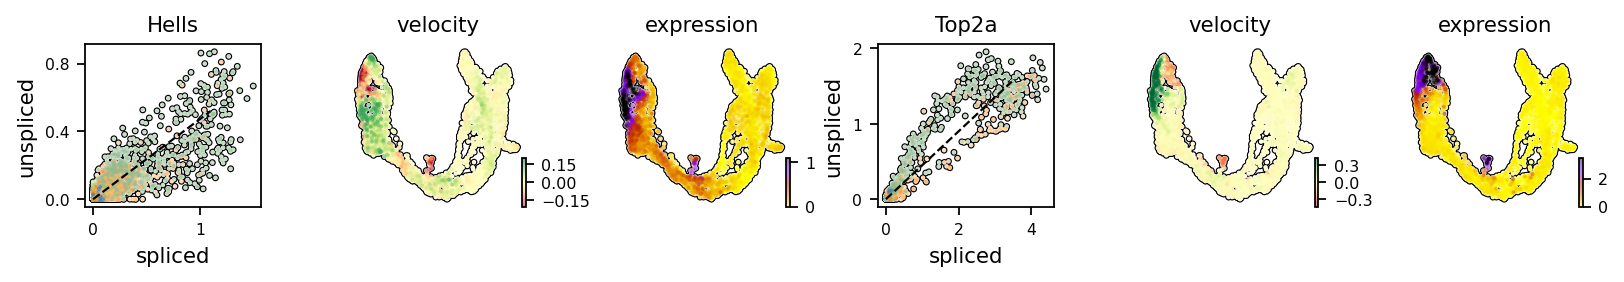

In [16]:
scv.pl.velocity(adata, ['Hells', 'Top2a'], ncols=2, add_outline=True)

## Speed and coherence

The speed of rate of differentiation is given by the length of the velocity vector. The coherence of the vector field (i.e., how  a velocity vector correlates with its neighboring velocities) provides a measure of confidence.

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


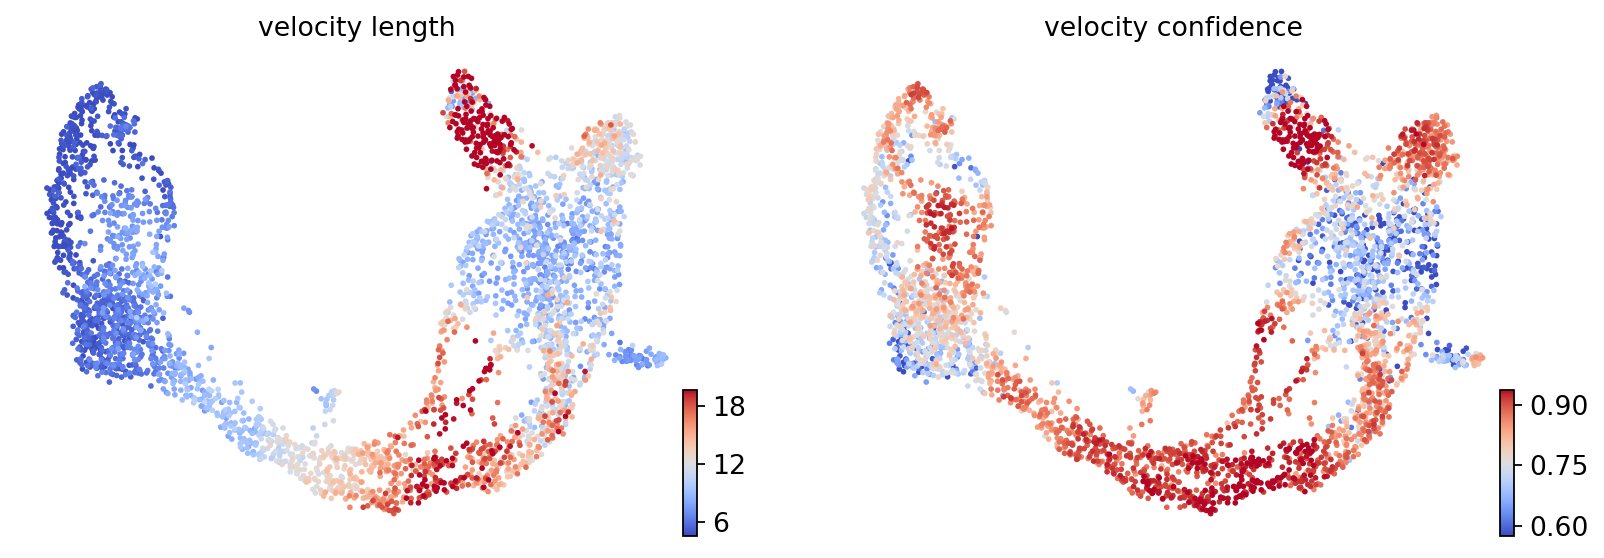

In [17]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])

These provide insights where cells differentiate at a slower/faster pace, and where the direction is un-/determined.

On cluster-level, the differentiation substantially speeds up after cell cycle exit (Ngn3 low EP), keeping the pace during Beta cell production while slowing down during Alpha cell production.

In [18]:
df = adata.obs.groupby('clusters')[['velocity_length', 'velocity_confidence']].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

## Velocity graph and pseudotime

Visualize the velocity graph to portray all velocity-inferred cell-to-cell connections/transitions. It can be confined to high-probabilty tranistions by setting a `threshold`. The graph indicated two phases of Epsilon cells production, coming from early and late Pre-endocrine cells.

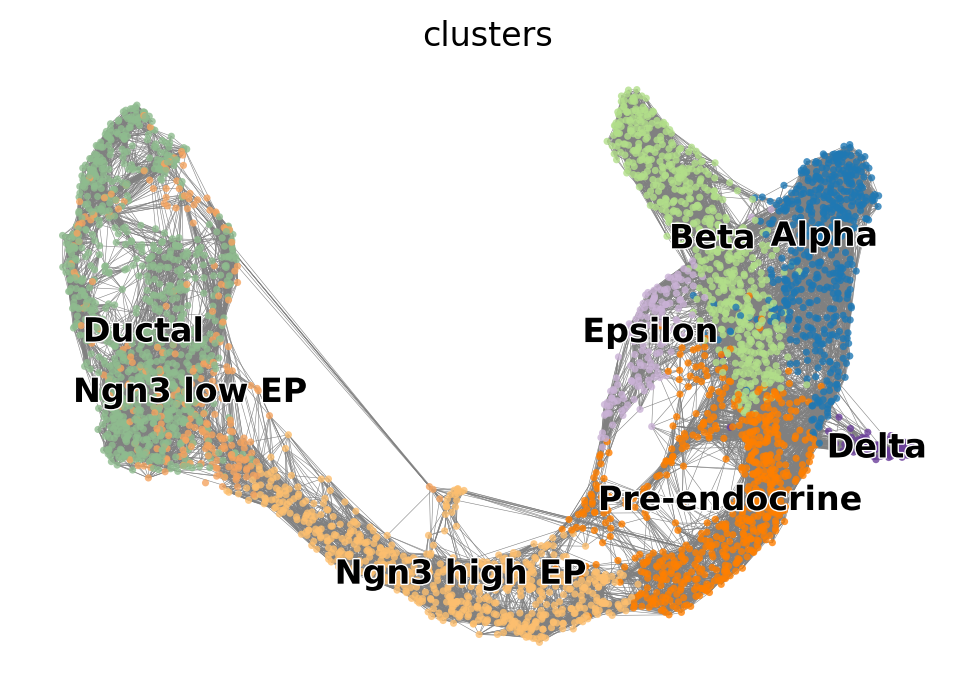

In [19]:
scv.pl.velocity_graph(adata, threshold=.1)

The graph can be used to draw descendents/ancestors coming form a specified cell. Here, a pre-endocrine cell is traced to its potential fate.

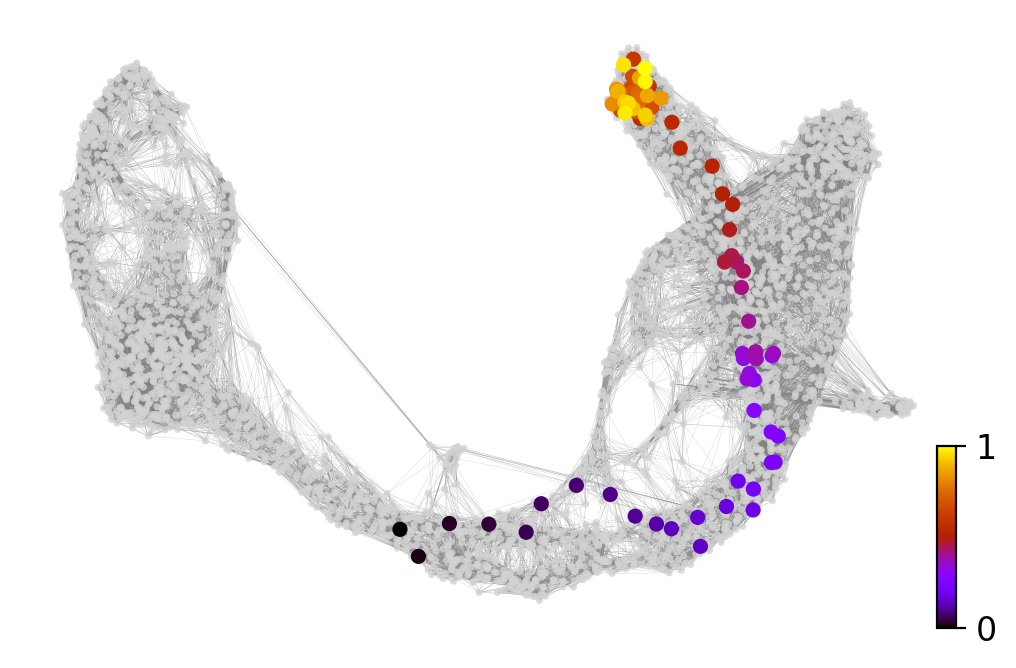

In [20]:
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=70)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

Based on the velocity graph, a velocity pseudotime can be computed. After inferring a distribution over root cells from the graph, it measures the average number of steps it takes to reach a cell after walking along the graph starting from the root cells.

Contrarily to difussion pseudotime, it implicity infers the root cells and is based on the directed velocity graph instead of the similarity-based diffusion kernel.

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


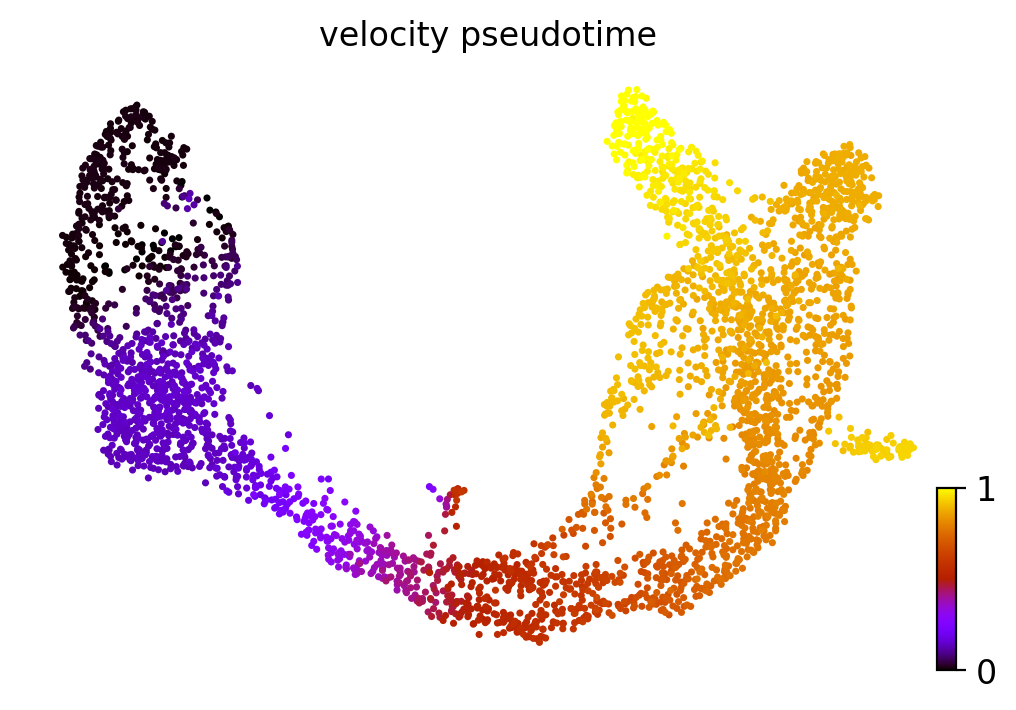

In [21]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

## PAGA velocity graph

Paga graph abstraction has benchmarked as top-performing method for trajectory inference. It provides a graph-like map of the data topology with weighted edges corresponding to the connectivity between two clusters. PAGA is extented by velocity-inferred directionality.

In [22]:
# this is needed due to a current bug
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='clusters')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


This reads from left/row to right/column, thus e.g. assigning a confident transition from Ductal to Ngn3 low EP.

This table can be summarized by a directed graph superimposed onto the UMAP embedding.

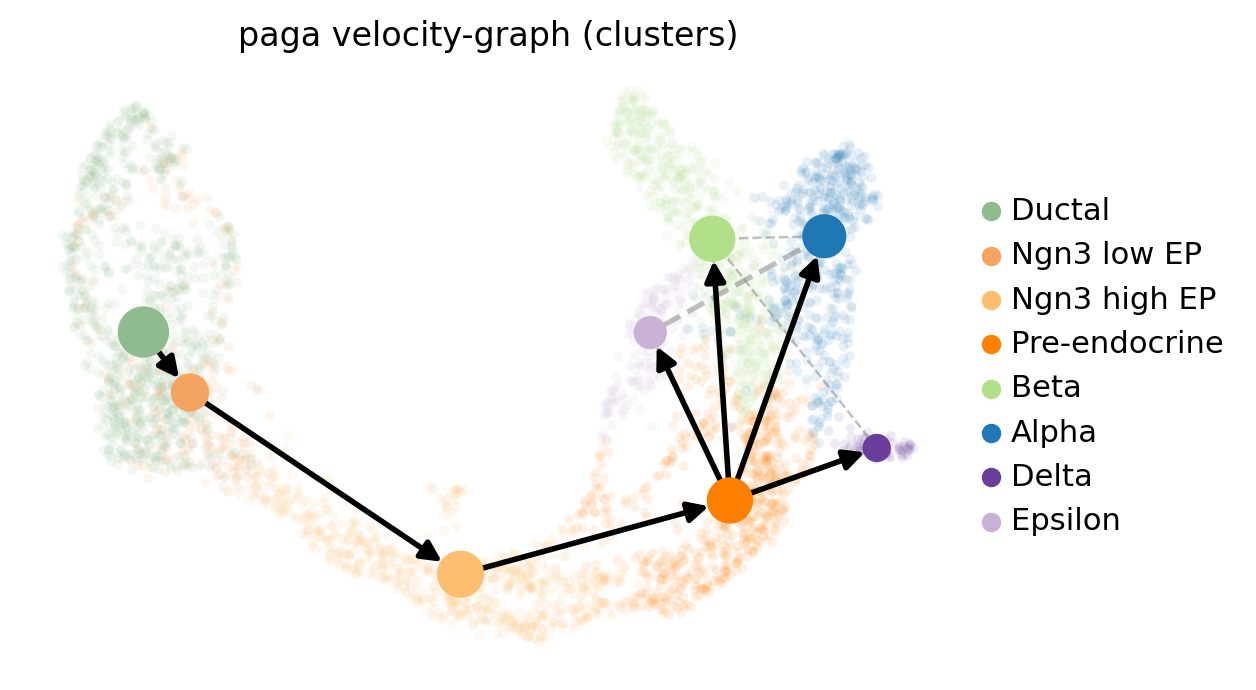

In [23]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
           min_edge_width=2, node_size_scale=1.5)